In [1]:
import pandas as pd
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
case_path = '../../data/cases/'
ca_cases = pd.read_csv(case_path + 'CA_JHU_cases.csv')
fl_cases = pd.read_csv(case_path + 'FL_JHU_cases.csv')
ga_cases = pd.read_csv(case_path + 'GA_JHU_cases.csv')
ny_cases = pd.read_csv(case_path + 'NY_JHU_cases.csv')

In [3]:
cases = {'California': ca_cases, 
         'Florida': fl_cases, 
         'Georgia': ga_cases, 
         'NewYork': ny_cases}

## Preprocess

In [4]:
def preprocess(df, state):
    #Set date to datetime obj
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    #start from rows where we have COVID Cases (?)
    df = df[df[state + '.JHU_ConfirmedCases.data'] > 0]
    #Given time constraints, just focus on confirmed cases
    ret_cols = ['date', state + '.JHU_ConfirmedCases.data']
    return df[ret_cols]

In [5]:
for state,df in cases.items():
    cases[state] = preprocess(df,state)
    print('{0}: {1} days available'.format(state, len(cases[state])))

California: 290 days available
Florida: 254 days available
Georgia: 259 days available
NewYork: 254 days available


## Split into train, 30 day test set

In [6]:
tt_cases = {}
for state,df in cases.items():
    temp = {}
    train, test = pm.model_selection.train_test_split(
        cases[state][state+'.JHU_ConfirmedCases.data'],
        test_size=30)
    temp['train'] = train
    temp['test'] = test
    tt_cases[state] = temp

## Model

### Initial models (just let auto arima do its thing)

California


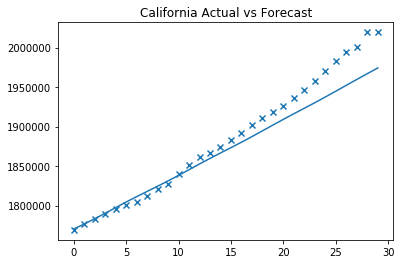

mse: 469521737.2298933
Florida


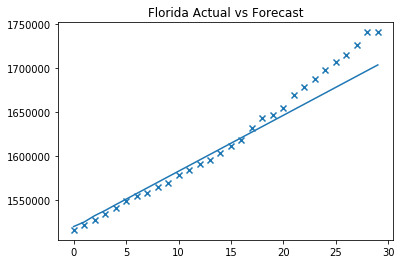

mse: 286952080.5957678
Georgia


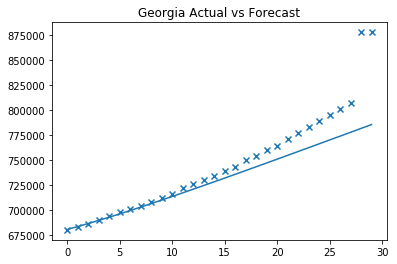

mse: 747038225.6468366
NewYork


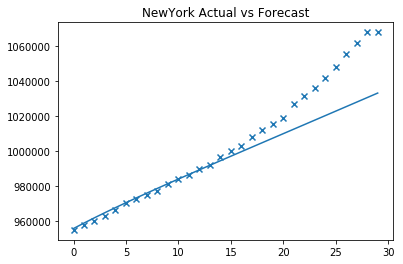

mse: 228619391.70453507


In [7]:
initial_models = {}
for state,df in tt_cases.items():
    print(state)
    temp = {}
    
    model = pm.auto_arima(tt_cases[state]['train'], suppress_warnings=True, 
                       max_p = 100, max_d = 100, max_q = 50,
                       seasonal=False)
    temp['model'] = model
    pred = model.predict(n_periods=30)
    x = np.arange(30)
    plt.scatter(x, tt_cases[state]['test'], marker='x')
    plt.plot(x, pred)
    plt.title(state + ' Actual vs Forecast')
    plt.show()

    mse = mean_squared_error(tt_cases[state]['test'], pred)
    temp['mse'] = mse
    print('mse:', mse)
    
    initial_models[state] = temp

In [8]:
for state, model in initial_models.items():
    print(model)

{'model': ARIMA(order=(3, 2, 3), scoring_args={}, suppress_warnings=True), 'mse': 469521737.2298933}
{'model': ARIMA(order=(2, 2, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 'mse': 286952080.5957678}
{'model': ARIMA(order=(1, 2, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False), 'mse': 747038225.6468366}
{'model': ARIMA(order=(1, 2, 3), scoring_args={}, suppress_warnings=True), 'mse': 228619391.70453507}
